**NOTE**: Please make a personal copy of this notebook by selecting 'File' > 'Save a copy in Drive' in the menu bars above.

If you are used to the shortcut Shift + Tab to see documentation then you should go to 'Tools' > 'Settings' > 'Editor' and uncheck the option 'Automatically trigger code completions'


In this lab we will start with some basics about Python and describe the machine learning framework that we will use extensively throughout the NYU AI School. We will highlight the details of this framework viz. the modules of interest to us and try to give you a realistic view of how to build a machine learning classifier in production. We will treat our machine learning model as a 'black box' as a lot of people often do in industry, much to their detriment, and demonstrate that even without knowing what machine learning is doing, we can generate good predictions for images. In future lectures it will become clearer what this model is doing, and we will introduce more layers and techniques to build faster, bigger, and better models! 

By the end of this lab you should be able to:

* Load, manipulate, and utilise an image dataset for machine learning
* Use a convolutional neural network for image classification



## Representing an Image as a Matrix of Integers

An image can be represented numerically by taking the numeric values of pixels representing the intensity of a particular primary color channel (eg. R, G, B). In grayscale images, there is only one channel. [Brandon Rohrer's post](https://www.kdnuggets.com/2020/01/convert-picture-numbers.html) has a nice visualization of this shown below.


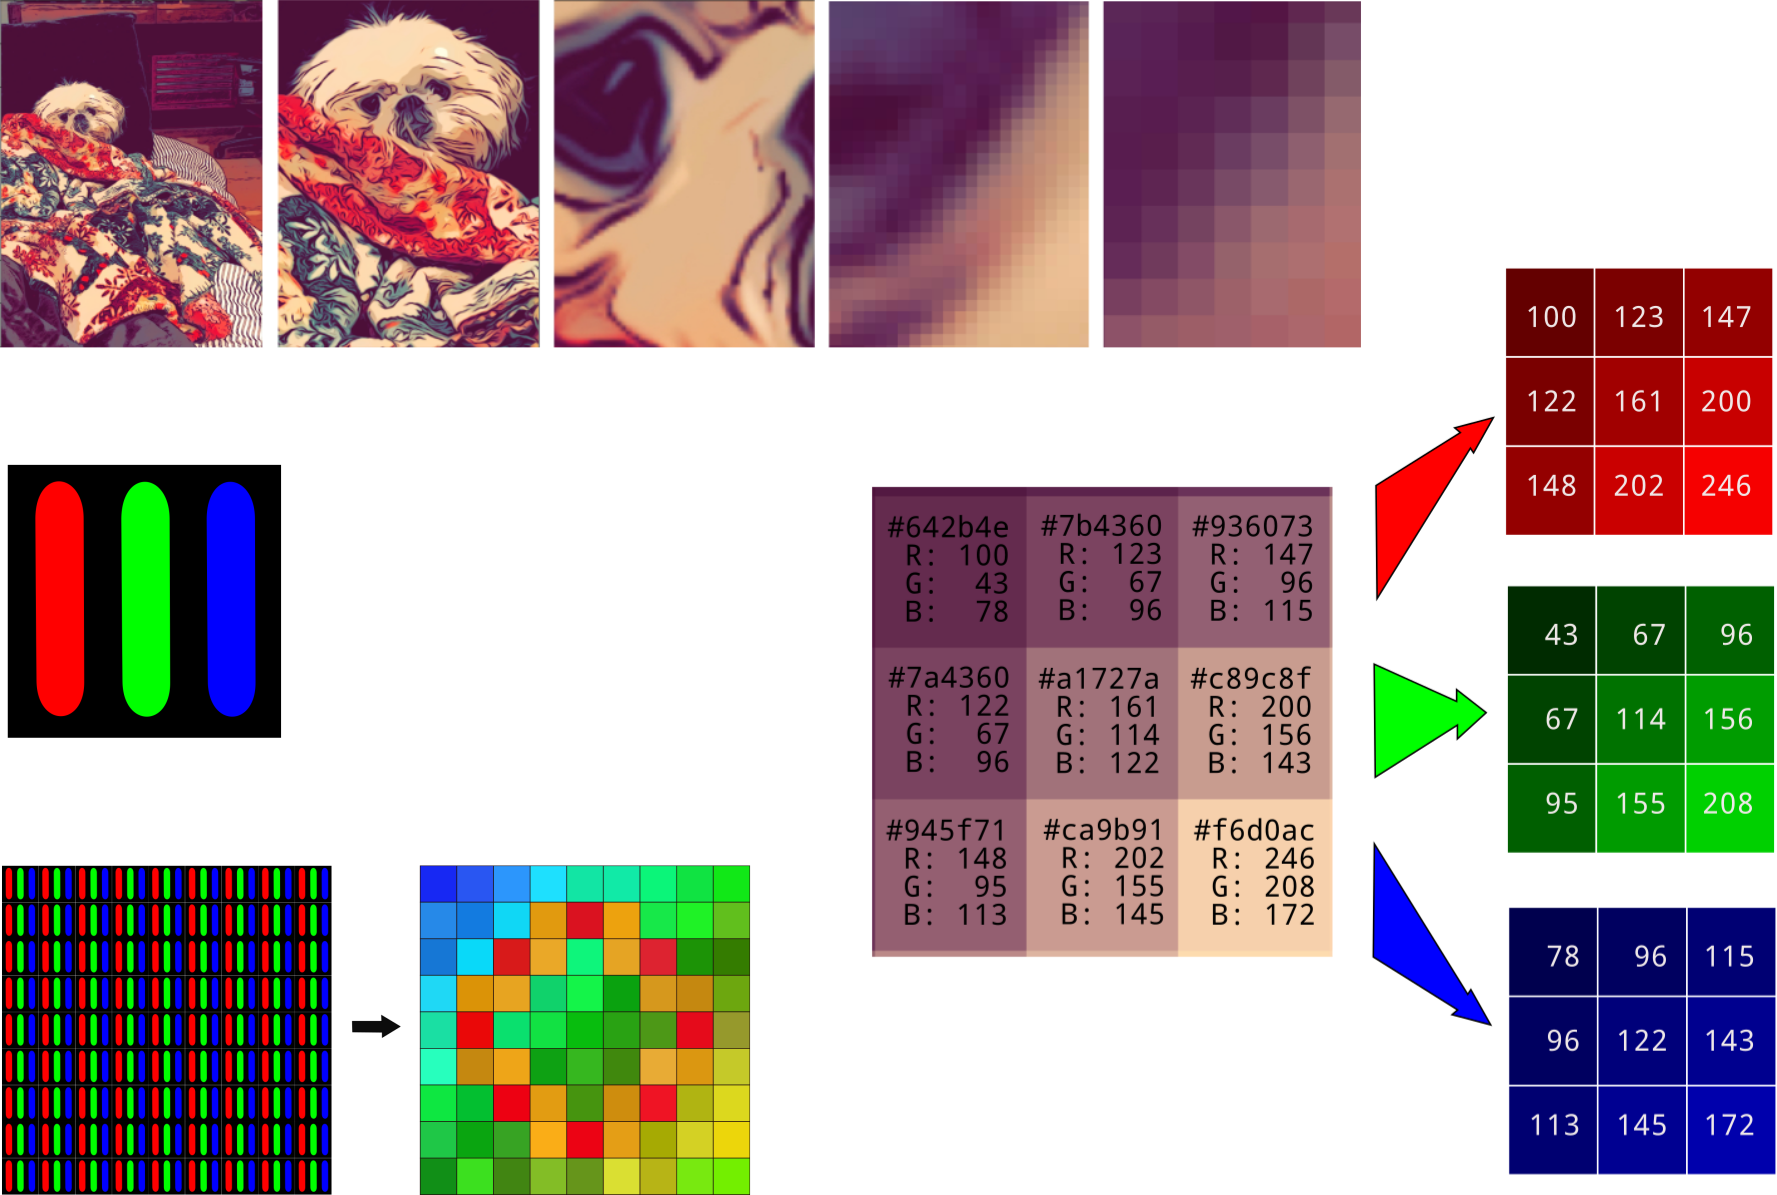

First let's install the three python libraries we will require: ``matplotlib``, ``torch``, and ``numpy`` using the pip package manager

In [1]:
!pip install matplotlib torch torchvision numpy

In [2]:
%matplotlib inline
# make all plots inline in the notebook


Example: Training a Classifier
=====================

There are three main tasks you will complete for this tutorial:
1. Define neural networks;
2. Compute loss;
3. Compute updates to the weights of the network.

For this tutorial, we will use the CIFAR10 dataset and the MNIST dataset.

- MNIST has images of 10 classes of digits from 0 - 9.
- CIFAR 10 has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.


Training an image classifier
----------------------------

1. Loading and normalizing CIFAR10

Using the ``torchvision`` module from the ``torch`` package, it’s extremely easy to load CIFAR10.



In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import PIL
from IPython.display import Image
import requests

1. Load and normalize the CIFAR10 training and test datasets using

The output of torchvision datasets are PILImage images of range [0, 255]. We first convert them to Tensors in the range [0,1] and then normalize by subtracting the mean and dividing by the standard deviation. 
<!-- We transform them to Tensors of normalized range [-1, 1]. -->

In [4]:
transform = transforms.Compose(                                 # chain two transforms together sequentially using transforms.Compose
    [transforms.ToTensor(),                                     # the first transform converts the input to a tensor
     transforms.Normalize(mean=(0.491, 0.482, 0.446), std=(0.247, 0.243, 0.261))])   # the second normalizes the tensors to have zero mean and unit variance

# first define the train dataset by using the inbuilt CIFAR 10 data
# use the inbuilt CIFAR 10 dataset and load it into a trainloader instance
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

# create the test dataset and load it into a testloader
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

# define the 10 classes of images that we are interested in identifying
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Note that the same normalization is used for both the train and test sets, after the mean and std are calculated only on the train set. 

Let us show some of the training images, for fun.



In [5]:
import matplotlib.pyplot as plt
import numpy as np

inv_normalize = transforms.Normalize(
    mean=[-0.491/0.247, -0.482/0.243, -0.446/0.261],
    std=[1/0.247, 1/0.243, 1/0.261]
)
make_viewable = transforms.Compose([
    inv_normalize,
    transforms.ToPILImage()
])


# here's a function to plot an image
def imshow(img):
    img = make_viewable(img) # unnormalize the normalized data
    plt.imshow(img)


 deer   dog  ship horse


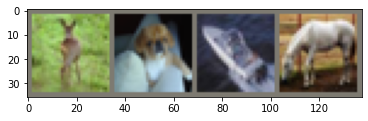

In [6]:
# get some random training images
# use an iterator over the trainloader to retrieve an image
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
# use the imshow function and torchvision.utils.make_grid to produce a grid of images
imshow(torchvision.utils.make_grid(images))

# print labels for all of the images underneath the grid of images
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Convolutions and Filters

Given any matrix of numbers that represents the input image, we want to find patterns in the matrix that allow us to identify the objects present in the image. One way of doing that is to convolve an image with a filter (or kernel) designed to reveal information present in the image. So the filter serves as a 'feature detector'. Here's an example from [this nicely illustrated post by Akshaj Verma](https://towardsdatascience.com/pytorch-basics-how-to-train-your-neural-net-intro-to-cnn-26a14c2ea29). Note that while this is a 2-dimensional convolution, we can similarly create single or higher-dimensional convolutions.

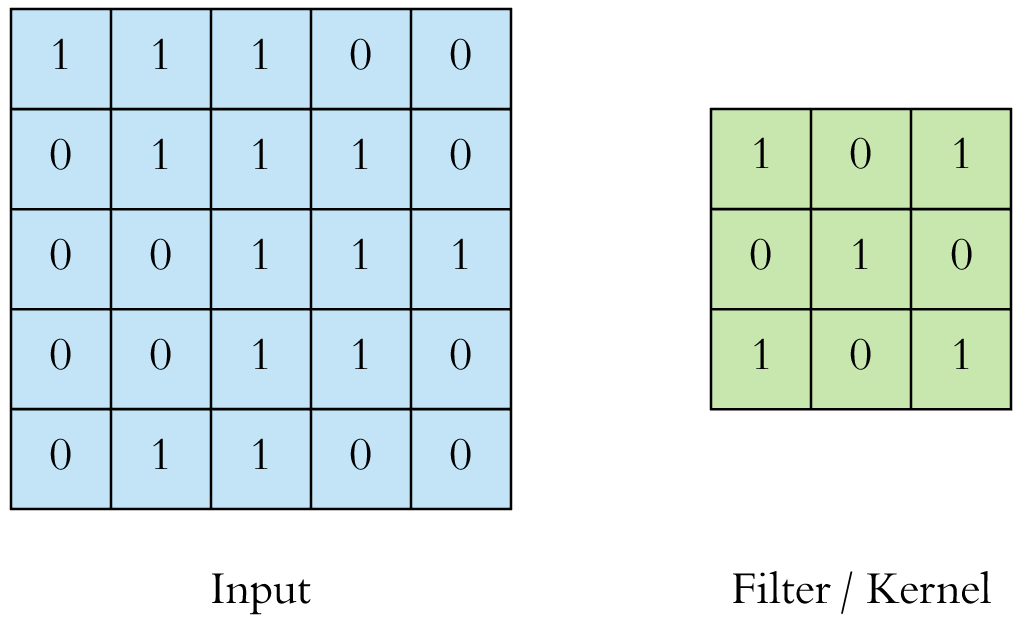

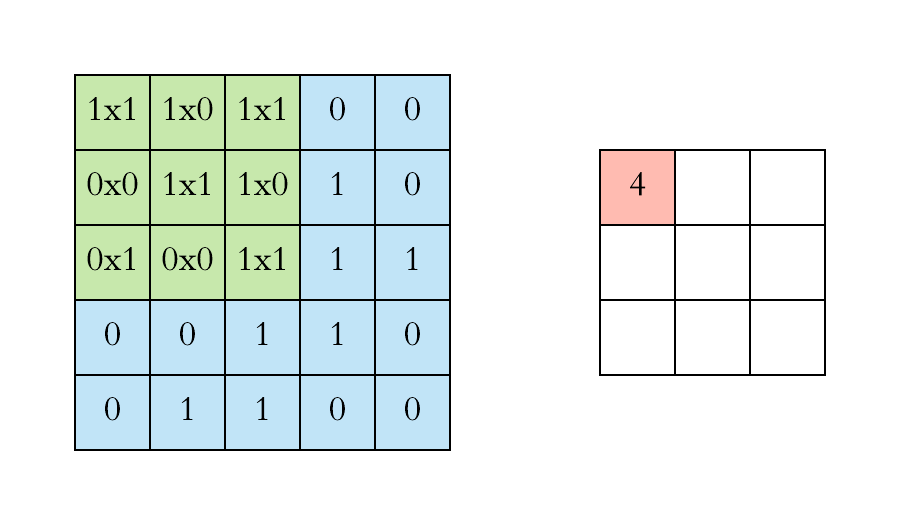


##### **Additional Background**
For some additional background and intuition on the use of Convolutional Filters in "traditional" Computer Vision (preceding the wide adoption of Convolutional Neural Networks), Utkarsh Sinha provides some nice visual [Image Convolution Examples](https://aishack.in/tutorials/image-convolution-examples/) here.  Notice how the choice of ***convolutional kernel*** affects the resulting output.  A CNN will allow us to learn the most optimal kernels rather than designing them by hand.



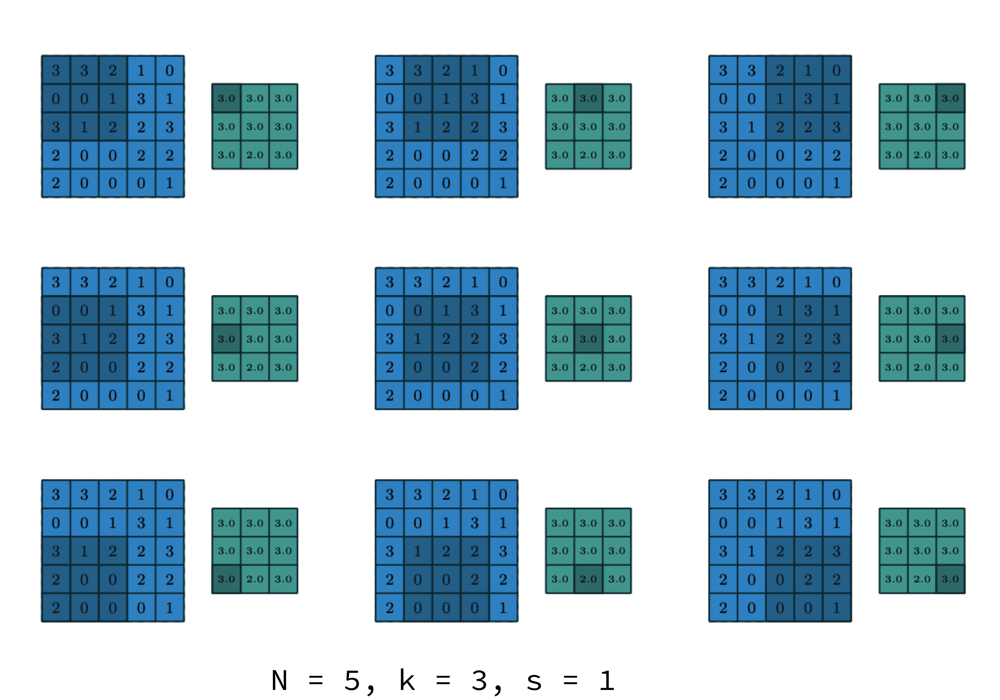

In [7]:
#@title Maxpooling
url = "https://i.imgur.com/BMvRg9v.png"
im = PIL.Image.open(requests.get(url, stream=True).raw).convert("RGB")
im = im.resize((1000,700))
im

## What does the output size of convolution depend on?

- Number of input feature maps
- Number of output feature maps
- Kernel size 
- Stride 
- Padding 


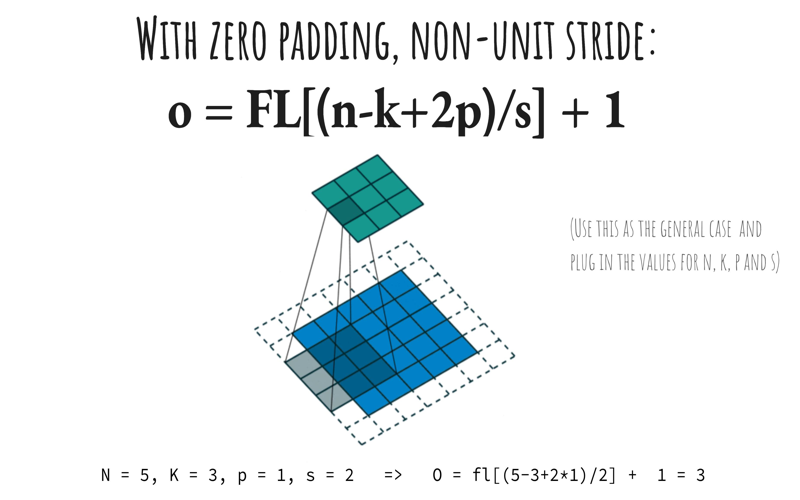

In [8]:
#@title Calculating size of a convolution
url = "https://i.imgur.com/GJ7oY2E.jpg"
im = PIL.Image.open(requests.get(url, stream=True).raw).convert("RGB")
im = im.resize((800,500))
im

### 1. Write Convolution code
Let's try writing our own code to define a convolution. Start with the two matrices given below and write your convolve function using pytorch 

In [9]:
import torch.nn.functional as F

n_channels = 1    # we consider a single channel only

sample_img = torch.Tensor(([
                             [1, 1, 1, 0, 0],
                             [0, 1, 1, 1, 0],
                             [0, 0, 1, 1, 1],
                             [0, 0, 1, 1, 0],
                             [0, 1, 1, 0, 0]
]))
sample_img = sample_img.view(1, 1, 5, 5)            # convert it to batch_size * n_channels * (image dimensions)

sample_kernel = torch.Tensor(([
                             [1, 0, 1],
                             [0, 1, 0],
                             [1, 0, 1]
]))
sample_kernel = sample_kernel.view(1, 1, 3, 3)      # convert it to batch_size * n_channels * (kernel dimensions)

convolved_output = F.conv2d(sample_img, sample_kernel, padding=0, stride=1)

In [10]:
convolved_output

tensor([[[[4., 3., 4.],
          [2., 4., 3.],
          [2., 3., 4.]]]])

### 2. Define a Convolutional Neural Network

We can place multiple layers of convolutions on top of each otner (also called 'stacking layers') to create a 'deep' convolutional neural network. We need the neural network to take an input of 3-channel images so our ``in_channels`` for the first convolutional layer must be 3.



In [11]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)         # arguments are in_channels, out_channels, kernel_size
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)        # calculate the in_channels based on the out_channels from the conv1 layer
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)           # calculate the arguments to the fc2 layer by looking at the line above and line below
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))    # combine a convolution, relu, and max pooling in a single line
        x = self.pool(F.relu(self.conv2(x)))    # again, combine a convolution, relu, and max pooling in a single line
        x = x.view(-1, 16 * 5 * 5)              # reshape the output as required
        x = F.relu(self.fc1(x))                 # place a relu on top of the fc1 layer
        x = F.relu(self.fc2(x))                 # place a relu on top of the fc2 layer
        x = self.fc3(x)                         # pass through the final fully connected layer fc3
        return x


net = Net()                                     # instantiate your neural network

### 3. Define a Loss function and optimizer

Let's use a Classification Cross-Entropy loss and Stochastic Gradient Descent.



In [12]:
import torch.optim as optim    # import the optim class from the torch.optim module

# define the criterion to be the CrossEntropyLoss class from the nn module
criterion = nn.CrossEntropyLoss()

# within torch.optim, for your SGD optimizer set the learning rate to 1e-3 and the momentum parameter to 0.9
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [13]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # forward + backward + optimize
        outputs = net(inputs)                         # first pass your inputs through your neural network instance to obtain outputs
        loss = criterion(outputs, labels)             # next, calculate the loss based on how well the outputs match the true labels

        # zero the parameter gradients
        optimizer.zero_grad()
        
        loss.backward()                               # next, backpropagate the loss through the neural network for calculating the gradient of the parameters
        optimizer.step()                              # finally, use the calculated gradient for updating the parameter values 

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.085
[1,  4000] loss: 1.726
[1,  6000] loss: 1.581
[1,  8000] loss: 1.535
[1, 10000] loss: 1.461
[1, 12000] loss: 1.417
[2,  2000] loss: 1.358
[2,  4000] loss: 1.349
[2,  6000] loss: 1.320
[2,  8000] loss: 1.282
[2, 10000] loss: 1.276
[2, 12000] loss: 1.293
Finished Training


### 5. Test the network on the test data

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



GroundTruth:    cat  ship  ship plane


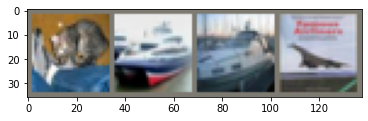

In [14]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [15]:
outputs = net(images)

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



Predicted:    cat  ship  ship plane


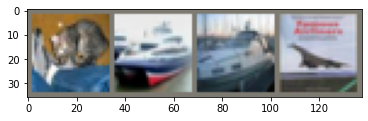

In [16]:
_, predicted = torch.max(outputs, 1) 

imshow(torchvision.utils.make_grid(images))
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

The results seem pretty good (if not, you might want to train your model for a larger number of epochs).

Let us look at how the network performs on the whole dataset.



In [17]:
correct = 0
total = 0
with torch.no_grad():                              # we don't want to calculate gradient updates when using the test data!
    for data in testloader:                        # recall that a dataloader is essentially a list of (image, label) tuples 
        images, labels = data
        outputs = net(images)                      # pass the test image through the network to obtain outputs
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 52 %


That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [18]:
class_correct = list(0. for i in range(10))        # create a list of 0's since you don't have any correct predictions yet
class_total = list(0. for i in range(10))
with torch.no_grad():

    for data in testloader:                        # iterate over your test loader
        images, labels = data
        outputs = net(images)

        # get the index of the maximum of the predictions for all classes 
        # and consider that as the predicted label
        # the second argument to torch.max() refers to the axis along which to calculate the max
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()        # check if your predictions match your labels
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()    # add the correct label at the right index
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))     # print the percentage accuracy 

Accuracy of plane : 56 %
Accuracy of   car : 53 %
Accuracy of  bird : 46 %
Accuracy of   cat : 20 %
Accuracy of  deer : 50 %
Accuracy of   dog : 51 %
Accuracy of  frog : 63 %
Accuracy of horse : 48 %
Accuracy of  ship : 77 %
Accuracy of truck : 59 %



How do we run these neural networks on the GPU?
```
  # use the GPU when we have larger models to train (remember to first change Colab Runtime > Change Runtime type > GPU)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  net.to(device)
```

## Visualizing Filters and Features

"Filters"

By visualizing the filters of the trained model, we can understand how CNN learns the complex Spatial and Temporal pixel dependencies present in the image.

When Deep Learning folks talk about “filters” what they’re referring to is the learned weights of the convolutions. 

By visualising the learned weights we can get some idea as to how well our network has learned. For example, if we see a lot of zeros then we’ll know we have many dead filters that aren’t going much for our network — a great opportunity to do some pruning for model compression.


Take a look at the code below for visualising the filters and then scroll down for an explanation of how it works.

Code from [HERE](https://towardsdatascience.com/visualizing-convolution-neural-networks-using-pytorch-3dfa8443e74e)

In [19]:
def plot_weights(model, layer, single_channel = True):
    #getting the weight tensor data
    if layer == 'conv1':
        weight_tensor = model.conv1.weight.data
        ncols = 6
    elif layer == 'conv2':
        weight_tensor = model.conv2.weight.data
        ncols = 12
  
    t = weight_tensor

    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()


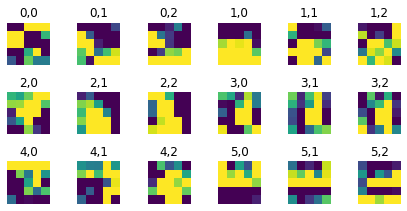

In [20]:
plot_weights(net, 'conv1', single_channel = True)


**Self-learning:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Data manipulation in Pytorch using torchvision datasets and DataLoaders
- Train a small convolutional neural network to classify images


Heavily based on the original [Pytorch CNN Tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

# Class Assignment

Having seen how we can build a CIFAR 10 classifier, we will write our own MNIST classifier that will identify which digit is present in a grayscale image. Note that the image will now have only one channel unlike CIFAR 10 that needed 3 channels. This means you will need to modify the CNN to accept these images as inputs.



1. Load and normalize the training data for MNIST

In [ ]:
# since the data distribution changes from CIFAR10 to MNIST, you can use the normalization 
#         transforms.Normalize((0.1307,), (0.3081,))
# as an exercise you might like to calculate it by yourself
transform_MNIST=transforms.Compose([
        # first convert it to a tensor
        # then normalize the image
        ])

# define train and test datasets and their corresponding dataloaders
trainset_MNIST = torchvision.datasets.MNIST('mnist_data', train=??, download=True,
                    transform=??)
trainloader_MNIST = torch.utils.data.DataLoader(??, batch_size=4,
                                          shuffle=True, num_workers=2)

testset_MNIST = ??
testloader_MNIST = ??

# define the mnist classes
classes_MNIST = (??)

Visualize some of the training data

In [ ]:
inv_normalize = transforms.Normalize(
    mean=[-0.1307/0.3081],
    std=[1/0.3081]
)
make_viewable = transforms.Compose([
    inv_normalize,
    transforms.ToPILImage()
])

# here's a function to plot an image
def imshow(img):
    img = make_viewable(img) # unnormalize the normalized data
    plt.imshow(img)

In [ ]:
# iterate over training data
dataiter = iter(??)
images, labels = dataiter.next()

# use imshow along with make_grid that was defined earlier
imshow(torchvision.utils.make_grid(??))

# print labels
print(' '.join('%5s' % classes_MNIST[labels[j]] for j in range(4)))

2. Define the Convolutional Neural Network arguments based on its given structure. Recall that the images are single-channel in this case.

In [ ]:
# understanding dimensions in convolutional neural networks
# also refer to this for visuals: https://towardsdatascience.com/the-most-intuitive-and-easiest-guide-for-convolutional-neural-network-3607be47480
print("initial image: ", images.shape)
conv1 = nn.Conv2d(1, 16, 3)
pool = nn.MaxPool2d(2, 2)
conv2 = nn.Conv2d(16, 32, 3)       

x = conv1(images)
print("after the 1st conv: (28 - 3 + 1) = ", x.shape)
x = pool(x)    
print("after the 1st pool: 26 // 2 = ", x.shape)
x = conv2(x)
print("after the 2nd conv: (28 - 3 + 1) = ", x.shape)
x = pool(x)    
print("after the 2nd pool: 11 // 2 = ", x.shape)


initial image:  torch.Size([4, 1, 28, 28])
after the 1st conv: (28 - 3 + 1) =  torch.Size([4, 16, 26, 26])
after the 1st pool: 26 // 2 =  torch.Size([4, 16, 13, 13])
after the 2nd conv: (28 - 3 + 1) =  torch.Size([4, 32, 11, 11])
after the 2nd pool: 11 // 2 =  torch.Size([4, 32, 5, 5])


In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, 3)        # arguments are in_channels, out_channels, kernel_size
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(??, 32, 3)       # calculate the in_channels based on the out_channels from the conv1 layer
    self.fc1 = nn.Linear(32 * 5 * 5, 120)   # this is the most crucial calculation to understand the cnn
    self.fc2 = nn.Linear(??, 10)           # calculate the arguments to the fc2 layer by looking at the line above and line below

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))    # combine a convolution, relu, and max pooling in a single line
    x = self.pool(F.relu(self.conv2(x)))    # again, combine a convolution, relu, and max pooling in a single line
    x = x.view(-1, ??)                      # reshape the output as required by fc1
    x = F.relu(self.fc1(x))                 # place a relu on top of the fc1 layer
    x = self.fc2(x)                         # pass through the final fully connected layer fc2
    return x
    x = self.fc3(x)                         

# instantiate the neural network
net_MNIST = CNN()

In [ ]:
# define the criterion to be the CrossEntropyLoss class from the nn module
criterion = ??

# within torch.optim, for your SGD optimizer set the learning rate to 1e-3 and the momentum parameter to 0.9
optimizer = ??

In [ ]:
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = ??  # initiate loss
    for i, data in enumerate(trainloader_MNIST, 0):
        # get the inputs and labels from data; data is a list of (input, label) tuples
        ??

        # zero the parameter gradients
        ??

        # forward + backward + optimize
        outputs = ??                                  # first pass your inputs through your neural network instance to obtain outputs
        loss = ??                                     # next, calculate the loss based on how well the outputs match the true labels
        ??                                            # next, backpropagate the loss through the neural network for calculating the gradient of the parameters
        optimizer.step()                              # finally, use the calculated gradient for updating the parameter values 

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

In [ ]:
class_correct = list(0. for i in range(10))        # create a list of 0's since you don't have any correct predictions yet
class_total = list(0. for i in range(10))
with torch.no_grad():

    for data in testloader_MNIST:                        # iterate over your test loader
        images, labels = ??
        outputs = ??

        # get the index of the maximum of the predictions for all classes 
        # and consider that as the predicted label
        # the second argument to torch.max() refers to the axis along which to calculate the max
        _, predicted = torch.max(outputs, 1)
        c = (?? == labels).squeeze()               # check if your predictions match your labels
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()    # add the correct label at the right index
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes_MNIST[i], 100 * class_correct[i] / class_total[i]))     # print the percentage accuracy 

Those are some really nice results! Can you visualize what's happening? (left to students).

**Hint:** Are the filters learning anything meaningful? What's an easy way to tell that they're not all zeros? (``plot_weights``)


**Important:** You should change your run-time type to GPU and uncheck the Tools > Settings > Editor > Automatically trigger code completions so that you can use the Shift + Tab shortcut to load documentation for functions. You should look up the arguments and return types for all the functions we use in the lab.  If you do this in the middle of the lab, you will lose the outputs from cells you have already run and will have to re-run them!

**Part 2: Transfer Learning for Computer Vision Tutorial**
==============================================

In the previous section, we wrote our own convolutional neural network and trained it on the CIFAR 10 dataset. We learnt that we can stack multiple layers on top of each other to create a deep neural network and perform better than we would with a shallow network. But with increasing depth come more parameters and to train deeper networks, we have higher computational requirements. One way to bypass this is to  In this tutorial, you will learn how to train a convolutional neural network for
image classification using transfer learning. You can read more about the transfer
learning at [Stanford CS231n class notes](https://cs231n.github.io/transfer-learning/).

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), *because* it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.

In [21]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

**Load Data**
==============

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

**Note** Download the data from [here](<https://download.pytorch.org/tutorial/hymenoptera_data.zip>) and extract it to the current directory. We do this running bash commands in the jupyter notebook as shown below:


### What is Validation Data?

When we train a machine learning model, we use training data to do so. While testing, we use test data. We do this because it would be unfair (or biased) to evaluate the model using the same data it has been trained on. This is because, it's like testing students using a final exam that comprises of questions that are exactly the same as their past homework questions--they can just memorize the homework answers and get a great score, but that is a poor measure of their knowledge of the subject. 

So validation data is just data that is held-out and not provided while training the model. We can then use it for evaluating different models by training them on the same datasets and comparing their validation accuracies on the validation dataset. While there are subtle differences, validation and test datasets are sometimes used interchangeably.

In [ ]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip -d data/



Typically if your image data is not structured properly, you would need to manually load the (image, label) tuples into a dataloader for further manipulation. 

But in this case we already have the desired structure with separate ``train`` and ``val`` folders and subfolders that are organized by label ('ant' or 'bees') that we can automatically load using the [``ImageFolder``](https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.ImageFolder) class from ``torchvision.datasets``.

You should look it up in the sidebar by clicking on the folder icon in the ``data`` folder.

In [23]:
# Data augmentation and normalization for training
# Normalization is important to bring the image -> tensor values into a 'normal' range
# An example of what this 'normal' range helps with is making convergence faster
# We also have normalization for the validation set of images
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),      # crop the image randomly to a specific size
        transforms.RandomHorizontalFlip(),      # flip the image horizontally at random
        transforms.ToTensor(),                  # transform it back to a tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),                 # for validation we do not want to randomly crop but rather Resize to 256 x 256
        transforms.CenterCrop(224),             # and then CenterCrop to 224 x 224
        transforms.ToTensor(),                  # then we apply both the same (last 2) transforms as above
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# define your data directory to be a string giving the path to the folder you just extracted 
# all your images to, that is the 'hymenoptera_data' folder within the 'data' folder
data_dir = 'data/hymenoptera_data'

# use the ImageFolder class from the datasets module to automate the reading in of training and validation data
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

# define a dictionary containing a training and a validation dataloader 
# remind yourself that a dataloader is just a list of (data, label) tuples that we can then manipulate easily
# for instance setting a batch size for loading or randomly shuffling the datasets
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

# define a dictionary with two keys, 'train' and 'val' 
# and values being the length of the dataset for each corresponding key in image_datasets
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# we can obtain the class labels from the .classes property of the ImageFolder for train
# the ImageFolder for validation will also contain a subset of the same class labels so we can just use the labels from train
class_names = image_datasets['train'].classes

# use the GPU since we have a larger model to train this time compared to the last lab we did
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

If you're wondering why normalize with these specific values (you should be!), it's just the mean and standard deviation of millions of images present in the ImageNet dataset which is a standard dataset used in computer vision tasks, particularly image classification. [Here's](https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2) a detailed explanation if you like.

Visualize a few images
--------------

Let's visualize a few training images so as to understand the data
augmentations.

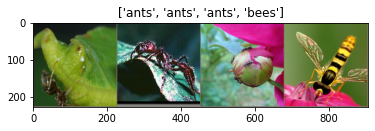

In [ ]:
def imshow(inp, title=None):
    """Plots the image represented by a tensor"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will illustrate:

- Using validation to compare model performance across epochs
- Saving the best model

**For advanced reading only:**
In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.

In [24]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=25):
    """
    Trains the model using the training data and returns the best model based on the validation data.
    """
    
    # note the current timestamp so that we can track how much time has elapsed
    since = time.time()

    # first step: set the best model to the current model's state_dict 
    # we will use copy.deepcopy to ensure a new copy of the original object is created
    # instead of just returning a reference to the same object
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # train the model for num_epochs
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                # in this mode, weights will be updated using the gradient
            else:
                model.eval()   # Set model to evaluate mode
                # no weight updates will occur during evaluation

            running_loss = 0.0
            running_corrects = 0

            # Iterate over the (data, label) tuples in the dataloader for train and val
            # calculate the loss and update the weights if you are in the train phase
            # if you want to recollect the different steps look up the last lab
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                # this is to ensure you do not accidentally update the weights
                # using gradients from much older steps
                optimizer.zero_grad()

                # pass the inputs through the model
                # also called the forward run of the model
                # we only calculate the gradient and perform weight updates 
                # if we are in the train phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            # advanced: use the learning rate scheduler
            # if phase == 'train' and scheduler is not None:
            #     scheduler.step()

            # the total loss for the epoch is divided by the number of images we have trained on
            epoch_loss = running_loss / dataset_sizes[phase]
            
            # similarly, the total accuracy is divided by the number of images
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # if the new model we are training performs better than the current model we have saved
            # then we overwrite the current weights with the new model's weights the same way
            # we also save the value of the best accuracy for the epoch
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    # calculate how much time has elapsed since we started training
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load the best model weights
    model.load_state_dict(best_model_wts)

    # return the best model
    return model

Visualizing the model predictions
----------
Generic function to display predictions for a few images



In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training

    # set the model to evaluation mode
    model.eval()
    images_so_far = 0

    # create a figure in matplotlib.pyplot
    fig = plt.figure()

    # we are not training so we do not want to update weights
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            
            # transfer the input tensor and the label to GPU
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # pass the validation data through the model to obtain the predictions
            outputs = model(inputs)

            # get the index of the maximum of the predictions for all classes 
            # and consider that as the predicted label
            _, preds = torch.max(outputs, 1)

            # create a grid and plot as many images as in num_images
            for j in range(inputs.size()[0]):
                # count how many images have been plotted
                images_so_far += 1
                # create a grid of subplots
                ax = plt.subplot(num_images//2, 2, images_so_far)
                # don't plot the axis
                ax.axis('off')
                # set each subplot's title as the predicted label for the image
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                # convert the jth row of the input tensor back to an image and plot it
                imshow(inputs.cpu().data[j])

                # stop plotting further images in the grid
                # return the model to the same training mode that it was in before
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer. Then further train the entire model on our dataset.

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2 because we have just two classes--ants and bees
# In other problems it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

# transfer the model to the GPU
model_ft = model_ft.to(device)

# define the loss function we want to use (CrossEntropyLoss)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# advanced: Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


Train and evaluate
------

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7652 Acc: 0.6230
val Loss: 0.2917 Acc: 0.8824

Epoch 1/24
----------
train Loss: 0.4389 Acc: 0.8033
val Loss: 0.2708 Acc: 0.9020

Epoch 2/24
----------
train Loss: 0.7809 Acc: 0.7377
val Loss: 0.5194 Acc: 0.8431

Epoch 3/24
----------
train Loss: 0.6087 Acc: 0.7869
val Loss: 0.3038 Acc: 0.8758

Epoch 4/24
----------
train Loss: 0.3501 Acc: 0.8607
val Loss: 0.6959 Acc: 0.7908

Epoch 5/24
----------
train Loss: 0.6081 Acc: 0.7951
val Loss: 0.6199 Acc: 0.8105

Epoch 6/24
----------
train Loss: 0.4821 Acc: 0.7869
val Loss: 0.7870 Acc: 0.7843

Epoch 7/24
----------
train Loss: 0.5448 Acc: 0.8033
val Loss: 0.3333 Acc: 0.8627

Epoch 8/24
----------
train Loss: 0.4282 Acc: 0.8484
val Loss: 0.3919 Acc: 0.8889

Epoch 9/24
----------
train Loss: 0.4455 Acc: 0.8197
val Loss: 0.2659 Acc: 0.8889

Epoch 10/24
----------
train Loss: 0.4359 Acc: 0.8443
val Loss: 0.4235 Acc: 0.8954

Epoch 11/24
----------
train Loss: 0.4127 Acc: 0.8197
val Loss: 0.3280 Acc: 0.9085

Ep

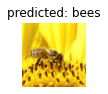

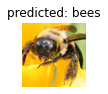

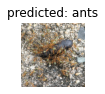

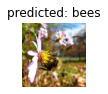

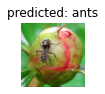

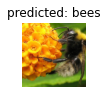

In [ ]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

So far, we get a pretrained model and finetune it on our dataset. But what if we want to use the features extracted from the images in other applications? 

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the [documentation](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward)


In [ ]:
# get the resnet18 pretrained model from torchvision.models 
model_conv = torchvision.models.resnet18(pretrained=True)

# Parameters of newly constructed modules have requires_grad=True by default
# so we need to iterate over each parameter in model_conv.parameters()
# and manually 
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

# transfer the model to the GPU
model_conv = model_conv.to(device)

# define the criterion as CrossEntropyLoss from the nn module
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# advanced: Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.


In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         num_epochs=25)

# advanced: use the learning-rate scheduler to adjsut your learning rate
# model_conv = train_model(model_conv, criterion, optimizer_conv,
#                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7811 Acc: 0.6107
val Loss: 0.2091 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.4682 Acc: 0.7992
val Loss: 0.2047 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.4730 Acc: 0.8033
val Loss: 0.2258 Acc: 0.9085

Epoch 3/24
----------
train Loss: 0.4003 Acc: 0.8238
val Loss: 0.1848 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.4208 Acc: 0.7869
val Loss: 0.2730 Acc: 0.8954

Epoch 5/24
----------
train Loss: 0.4390 Acc: 0.8238
val Loss: 0.1819 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.7152 Acc: 0.7049
val Loss: 0.2583 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.7267 Acc: 0.7336
val Loss: 0.1879 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3589 Acc: 0.8402
val Loss: 0.5262 Acc: 0.8366

Epoch 9/24
----------
train Loss: 0.5590 Acc: 0.7787
val Loss: 0.2439 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.5992 Acc: 0.7746
val Loss: 0.2785 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.5268 Acc: 0.7828
val Loss: 0.4126 Acc: 0.8758

Ep

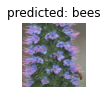

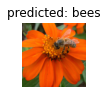

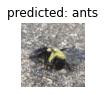

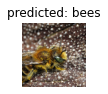

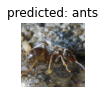

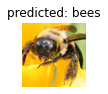

In [ ]:
# call the visualize_model function with the trained model as an argument
visualize_model(model_conv)

# turn off interactive mode for plots
plt.ioff()

# show the plot that has been generated
plt.show()

Reference
---------

Heavily based on the Pytorch Tutorial by [Sasank Chilamkurthy](https://chsasank.github.io)

# Class Assignment

We saw how to finetune the ResNet-18 model on our dataset. But what if we want to use a different model as a feature extractor instead of the ResNet-18 model? Let's try using an ``googlenet`` model from ``torchvision.models`` instead. Remember that we want it to be pretrained!

In [ ]:
# get the googlenet pretrained model from torchvision.models 
model_gnet = torchvision.models.googlenet(pretrained=True)

# Parameters of newly constructed modules have requires_grad=True by default
# so we need to iterate over each parameter in model_conv.parameters()
# and manually 
for param in model_gnet.parameters():
    param.requires_grad = ??

# we are adding a fully connected layer on top 
# with the final number of output classes that we need
num_ftrs_gnet = ??
model_gnet.fc = ??

# transfer the model to the GPU
model_gnet = ??

# define the criterion as CrossEntropyLoss from the nn module
criterion_gnet = ??

# Observe that only parameters of final layer are being optimized as
# opposed to before
optimizer_gnet = ??

Now let's train the last layer of the model to predict ants and bees from our dataset.

In [ ]:
model_conv = ??